In [7]:
import os
import cv2
import pandas as pd
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import shutil

np.random.seed(123)

%matplotlib inline

In [8]:
data_path = "../testDataset/"
output_path = "../testDataset/RESULT/"
train_path = "../testDataset/train/"
validation_path = "../testDataset/validation/"
test_path = "../testDataset/test/"
for path in [output_path,train_path,validation_path]:
    if not os.path.isdir(path):
        os.mkdir(path)

In [9]:
backgrounds = [[data_path+"background0{}".format(el),"bg0{}".format(el)] for el in range(1,6)]
backgrounds

[['../testDataset/background01', 'bg01'],
 ['../testDataset/background02', 'bg02'],
 ['../testDataset/background03', 'bg03'],
 ['../testDataset/background04', 'bg04'],
 ['../testDataset/background05', 'bg05']]

### Create dataframe from xml files

In [10]:
%%time
DF_l = []
for background_tup in backgrounds:
    print(background_tup)
    background = background_tup[0]
    bg = background_tup[1]
    
    xmls = [el for el in os.listdir(background) if ".xml" in el]
    for xml in xmls:
        xtree = et.parse(os.path.join(background,xml))
        xroot = xtree.getroot()
        xs, ys, idxs, names = [], [], [], []
        for node in xroot.iter('point'): 
            names.append(node.attrib["name"])
            xs.append(node.attrib["x"])
            ys.append(node.attrib["y"])
        for node in xroot.iter('frame'): 
            idxs.append(node.attrib["index"])
        # idxs = [x for item in idxs for x in repeat(item, 4)]
        idxs = [bg+"-"+xml.split(".gt")[0]+"-f"+idx+".jpg" for idx in idxs]

        temp_df = pd.DataFrame(list(zip(names,xs,ys)),columns=["names","xs","ys"])
        blx = temp_df[temp_df["names"]=="bl"]["xs"]
        bly = temp_df[temp_df["names"]=="bl"]["ys"]
        tlx = temp_df[temp_df["names"]=="tl"]["xs"]
        tly = temp_df[temp_df["names"]=="tl"]["ys"]
        
        brx = temp_df[temp_df["names"]=="br"]["xs"]
        bry = temp_df[temp_df["names"]=="br"]["ys"]
        trx = temp_df[temp_df["names"]=="tr"]["xs"]
        Try = temp_df[temp_df["names"]=="tr"]["ys"]
        
        df = pd.DataFrame(list(zip(idxs,blx,bly,tlx,tly,brx,bry,trx,Try)),
                          columns=["filenames","BLx","BLy","TLx","TLy","BRx","BRy","TRx","TRy"])
        DF_l.append(df)


['../testDataset/background01', 'bg01']
['../testDataset/background02', 'bg02']
['../testDataset/background03', 'bg03']
['../testDataset/background04', 'bg04']
['../testDataset/background05', 'bg05']
CPU times: user 1.41 s, sys: 4.29 ms, total: 1.42 s
Wall time: 1.41 s


In [11]:
pd.concat(DF_l).shape

(24889, 9)

In [12]:
sample_df = pd.concat(DF_l).sample(7000)

In [15]:
sample_df.to_csv("sample_df.csv",sep=";",index=False)

### Convert videos to frames

In [ ]:
%%time
# save all videos to frames
for background_tup in backgrounds[:]:
    print(background_tup)
    background = background_tup[0]
    bg = background_tup[1]

    videos = [el for el in os.listdir(background) if ".avi" in el]
    for video in videos:
        im_path = os.path.join(background,video)

        vidcap = cv2.VideoCapture(im_path)
        length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
        print( length )

        success,image = vidcap.read()
        count = 0
        while success:
            output_file = "{}-{}-f{}.jpg".format(bg, video.replace(".avi",""), count)    
            cv2.imwrite(os.path.join(output_path,output_file), image)     # save frame as JPEG file      
            success,image = vidcap.read()
    #         print('Read a new frame: ', success)
            count += 1

### Visualize some images

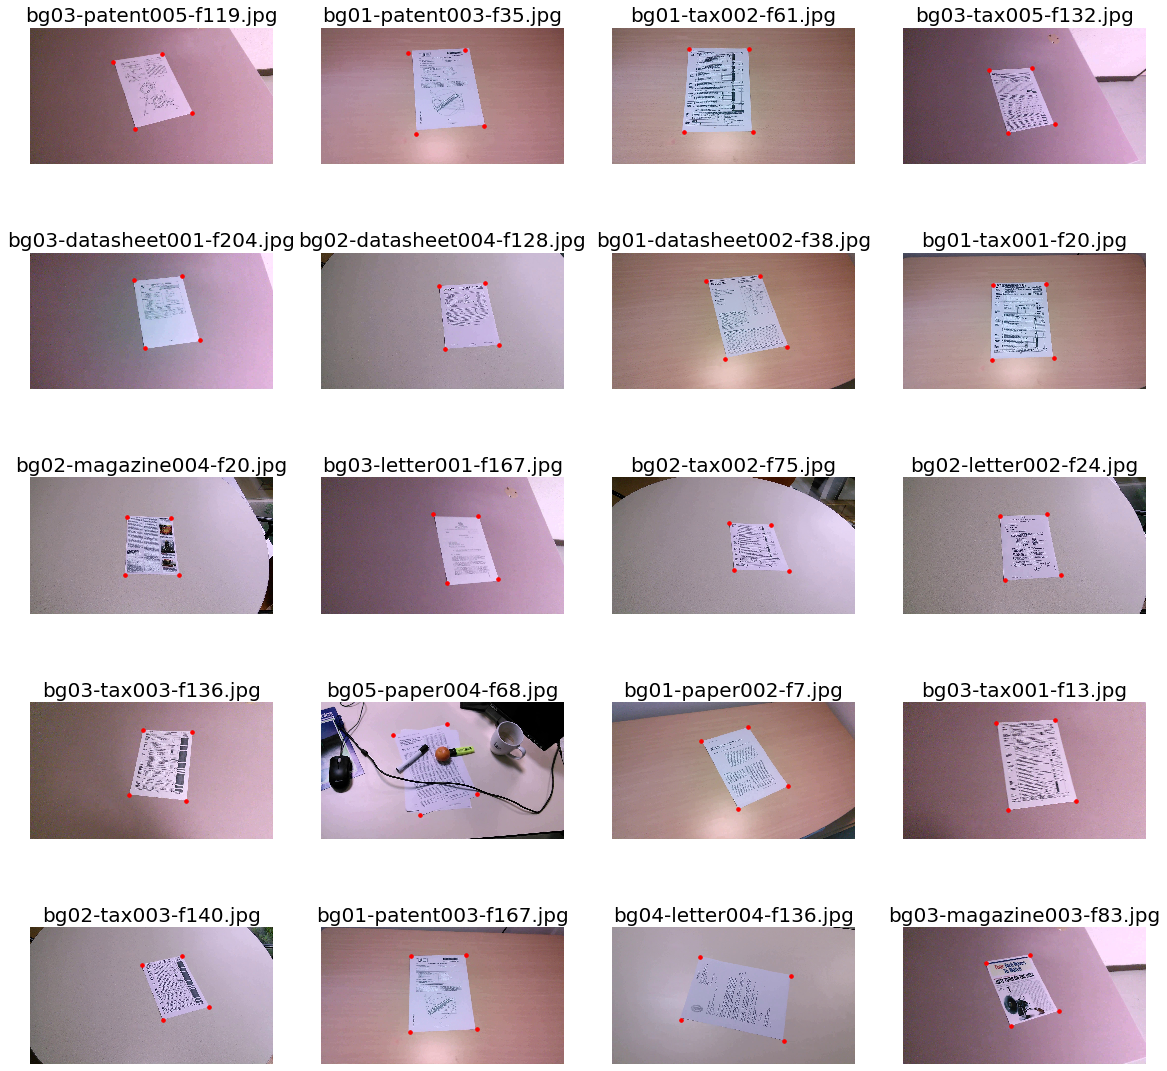

In [14]:
# show results
def show_landmarks(name,ax,image, landmarks):
    """Show image with landmarks"""
    ax.imshow(image, interpolation='nearest')
    ax.scatter(landmarks[:, 0], landmarks[:, 1], s=50, marker='.', c='r')
    ax.set_title(name,fontsize=20)
    ax.axis("off")
    
fig = plt.figure(figsize=(20,20))

ax1=0
for i,n in enumerate(range(20)):
    
    img_name = sample_df.iloc[n, 0]
    landmarks = sample_df.iloc[n, 1:].values
    landmarks = landmarks.astype('float').reshape(-1, 2)
    
    ax1 = fig.add_subplot(5,4,i+1)
    show_landmarks(str(img_name),ax1,Image.open(os.path.join(output_path, img_name)),landmarks)
    ax1.set
plt.show()

### Take off images that has not being converted

In [17]:
# Remove Images not in sample (for space reasons)
not_found = set(sample_df.filenames.values.tolist()) - set(os.listdir(output_path))
to_remove = set(os.listdir(output_path)) - set(sample_df.filenames.values.tolist())

clean_df = sample_df[~sample_df.filenames.isin(not_found)]

# for file in to_remove:
#     os.remove(os.path.join(output_path,file))
clean_df.to_csv("clean_df.csv",sep=";",index=False)

In [18]:
clean_list = pd.read_csv("DeePaperScan/clean_df.csv",sep=";")['filenames'].tolist()
set(clean_list) - set(os.listdir("DeePaperScan/train/"))

FileNotFoundError: [Errno 2] No such file or directory: 'DeePaperScan/train/'

### Split dataframe

In [16]:
# Split files to train / validation
from sklearn.model_selection import train_test_split

train, val = train_test_split(clean_df, test_size=0.01)

for sample in [[train,train_path],[val,validation_path]]:
    filenames = sample[0]["filenames"].values.tolist()
    for filename in filenames:
        shutil.copyfile(os.path.join(output_path,filename),os.path.join(sample[1],filename))

NameError: name 'clean_df' is not defined

In [14]:
train.shape,len(os.listdir(train_path)), clean_df.shape

((6899, 9), 6969, (6969, 9))

### RESIZE IMAGES & ANNOTATIONS

In [15]:
# https://github.com/fizyr/keras-retinanet/blob/8f7e7414db193832572773ea503c26edab405b96/keras_retinanet/utils/image.py
def resize_image(img, min_side=800, max_side=1333):
    """ Resize an image such that the size is constrained to min_side and max_side.
    Args
        min_side: The image's min side will be equal to min_side after resizing.
        max_side: If after resizing the image's max side is above max_side, resize until the max side is equal to max_side.
    Returns
        A resized image.
    """
    (rows, cols, _) = img.shape

    smallest_side = min(rows, cols)

    # rescale the image so the smallest side is min_side
    scale = min_side / smallest_side

    # check if the largest side is now greater than max_side, which can happen
    # when images have a large aspect ratio
    largest_side = max(rows, cols)
    if largest_side * scale > max_side:
        scale = max_side / largest_side

    # resize the image with the computed scale
    img = cv2.resize(img, None, fx=scale, fy=scale)
    return img, scale

In [16]:
%%time

X_val = []
y_val = []
X_train = []
y_train = []

for IDX,DF_path in enumerate([[train,train_path],[val,validation_path]]):
    for img_name in DF_path[0].filenames.values.tolist():
        img = Image.open(os.path.join(DF_path[1], img_name))
        annotation = np.array(DF_path[0][DF_path[0].filenames==img_name].drop("filenames",axis=1),dtype = 'float')
        
        # convert the image to grayscale
        gs_image = np.array(img.convert(mode='L')).reshape(1080,1920,1)
        # resize image
        image_sc, scale = resize_image(gs_image,300,350)
        image_sc = image_sc.reshape(image_sc.shape[0],image_sc.shape[1],1)
        # apply resizing to annotations too
        annotation_sc = annotation * scale

        if IDX==0:
            X_train.append(image_sc)
            y_train.append(annotation_sc)
        else:
            X_val.append(image_sc)
            y_val.append(annotation_sc)

X_train_ = np.array(X_train, dtype='float')
y_train_ = np.array(y_train,dtype='float')
y_train_ = y_train_.reshape(y_train_.shape[0],y_train_.shape[2])

X_val_ = np.array(X_val, dtype='float')
y_val_ = np.array(y_val,dtype='float')
y_val_ = y_val_.reshape(y_val_.shape[0],y_val_.shape[2])

CPU times: user 2min 28s, sys: 640 ms, total: 2min 28s
Wall time: 2min 29s


In [15]:
#check if landmarks well positioned after image scaling
IDX = np.random.randint(0,4000)
landmarks = y_train_[IDX].astype('float').reshape(-1, 2)

show_landmarks(Image.fromarray(X_train[IDX].reshape(X_train_.shape[1],X_train_.shape[2])),landmarks)
# show_landmarks(Image.fromarray(X_train[IDX]),landmarks)
plt.show()

ax1 = fig.add_subplot(5,4,i+1)
    show_landmarks(str(img_name),ax1,Image.open(os.path.join(output_path, img_name)),landmarks)
    ax1.set

NameError: name 'y_train_' is not defined

## KERAS MODEL TRAINING

In [18]:
from tensorflow.keras.layers import Conv2D,Dropout,Dense,Flatten,Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16, preprocess_input

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

# from tensorflow.keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LeakyReLU, Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

H = X_train_.shape[1]
W = X_train_.shape[2]
OUT = 8

In [111]:
H,W

(197, 350)

In [92]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

def SimpleCNN(withDropout=True):
    '''
    WithDropout: If True, then dropout regularlization is added.
    This feature is experimented later.
    '''
    model = Sequential()
    model.add(Conv2D(32,(3, 3), input_shape = (H, W, 1)))
    model.add(Activation('relu')) ## 96 - 3 + 2
    model.add(MaxPooling2D(pool_size = (2,2))) ## 96 - (3-1)*2
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Conv2D(64,(2,2)))
    model.add(Activation('relu')) ## 
    model.add(MaxPooling2D(pool_size = (2,2)))
    if withDropout:
        model.add(Dropout(0.1))
    
    model.add(Conv2D(128,(2,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Flatten())
    
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(OUT))
    sgd = SGD(lr=0.01,momentum = 0.9,nesterov=True)
#     model.compile(loss="mean_squared_error",optimizer=sgd)
    model.compile(optimizer=RMSprop(), 
              loss='mean_squared_logarithmic_error',#'mean_squared_error',
              metrics=['mae'])
    return(model)
simplecnn = SimpleCNN()
simplecnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 195, 348, 32)      320       
_________________________________________________________________
activation_10 (Activation)   (None, 195, 348, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 97, 174, 32)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 97, 174, 32)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 96, 173, 64)       8256      
_________________________________________________________________
activation_11 (Activation)   (None, 96, 173, 64)       0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 86, 64)       

In [91]:
#check if gpu is activated

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

Num GPUs Available:  1


True

In [93]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
path_weights = "./simplecnn.h5"

es   = EarlyStopping(monitor='val_loss', patience = 100, mode='min')
mc = ModelCheckpoint(filepath = path_weights, monitor='val_loss', mode='min',save_best_only = True, verbose=2)
h0 = simplecnn.fit(X_train_,y_train_,epochs = 1000,batch_size = 64,validation_split = 0.1,
                   callbacks=[mc], verbose=2) #edit

Train on 6209 samples, validate on 690 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 3.93577, saving model to ./simplecnn.h5
6209/6209 - 12s - loss: 4.8566 - mae: 357.1788 - val_loss: 3.9358 - val_mae: 53.9393
Epoch 2/1000

Epoch 00002: val_loss improved from 3.93577 to 2.87441, saving model to ./simplecnn.h5
6209/6209 - 11s - loss: 2.4338 - mae: 62.4759 - val_loss: 2.8744 - val_mae: 96.6276
Epoch 3/1000

Epoch 00003: val_loss improved from 2.87441 to 1.98767, saving model to ./simplecnn.h5
6209/6209 - 11s - loss: 2.0343 - mae: 53.0393 - val_loss: 1.9877 - val_mae: 42.9535
Epoch 4/1000

Epoch 00004: val_loss did not improve from 1.98767
6209/6209 - 10s - loss: 2.0051 - mae: 48.7155 - val_loss: 2.0162 - val_mae: 36.6214
Epoch 5/1000

Epoch 00005: val_loss did not improve from 1.98767
6209/6209 - 10s - loss: 1.9931 - mae: 45.7707 - val_loss: 2.0633 - val_mae: 55.6095
Epoch 6/1000

Epoch 00006: val_loss did not improve from 1.98767
6209/6209 - 10s - loss: 1.9844 - mae: 

Epoch 53/1000

Epoch 00053: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0147 - mae: 12.3685 - val_loss: 0.0900 - val_mae: 34.3008
Epoch 54/1000

Epoch 00054: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0132 - mae: 12.1559 - val_loss: 0.0534 - val_mae: 25.0537
Epoch 55/1000

Epoch 00055: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0141 - mae: 11.8628 - val_loss: 0.0689 - val_mae: 31.6018
Epoch 56/1000

Epoch 00056: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0129 - mae: 11.8815 - val_loss: 0.0487 - val_mae: 27.1758
Epoch 57/1000

Epoch 00057: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0157 - mae: 12.3143 - val_loss: 0.0931 - val_mae: 35.7777
Epoch 58/1000

Epoch 00058: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0139 - mae: 11.9623 - val_loss: 0.2617 - val_mae: 54.1199
Epoch 59/1000

Epoch 00059: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0134 - m

Epoch 108/1000

Epoch 00108: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0108 - mae: 10.7343 - val_loss: 0.0958 - val_mae: 35.3925
Epoch 109/1000

Epoch 00109: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0255 - mae: 12.1977 - val_loss: 0.1056 - val_mae: 38.3582
Epoch 110/1000

Epoch 00110: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0110 - mae: 10.6342 - val_loss: 0.2519 - val_mae: 53.7080
Epoch 111/1000

Epoch 00111: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0116 - mae: 10.7431 - val_loss: 0.1600 - val_mae: 44.1818
Epoch 112/1000

Epoch 00112: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0148 - mae: 11.0885 - val_loss: 0.1867 - val_mae: 47.5680
Epoch 113/1000

Epoch 00113: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0105 - mae: 10.6396 - val_loss: 0.1103 - val_mae: 39.6157
Epoch 114/1000

Epoch 00114: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0

Epoch 163/1000

Epoch 00163: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0127 - mae: 10.5810 - val_loss: 0.1074 - val_mae: 38.2985
Epoch 164/1000

Epoch 00164: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0106 - mae: 10.5785 - val_loss: 0.2012 - val_mae: 49.5855
Epoch 165/1000

Epoch 00165: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0100 - mae: 9.9299 - val_loss: 0.0952 - val_mae: 34.5757
Epoch 166/1000

Epoch 00166: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0103 - mae: 10.2938 - val_loss: 0.0953 - val_mae: 35.2299
Epoch 167/1000

Epoch 00167: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0131 - mae: 10.6804 - val_loss: 0.1317 - val_mae: 41.9644
Epoch 168/1000

Epoch 00168: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0630 - mae: 20.5796 - val_loss: 0.0782 - val_mae: 33.5242
Epoch 169/1000

Epoch 00169: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.01

Epoch 218/1000

Epoch 00218: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0089 - mae: 9.7488 - val_loss: 0.0648 - val_mae: 31.3720
Epoch 219/1000

Epoch 00219: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0100 - mae: 10.0598 - val_loss: 0.1388 - val_mae: 42.3653
Epoch 220/1000

Epoch 00220: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0089 - mae: 9.6224 - val_loss: 0.0618 - val_mae: 30.7236
Epoch 221/1000

Epoch 00221: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0103 - mae: 9.8588 - val_loss: 0.1107 - val_mae: 40.1685
Epoch 222/1000

Epoch 00222: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0129 - mae: 10.4191 - val_loss: 0.1505 - val_mae: 44.6703
Epoch 223/1000

Epoch 00223: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0094 - mae: 9.8068 - val_loss: 0.0524 - val_mae: 28.2642
Epoch 224/1000

Epoch 00224: val_loss did not improve from 0.03362
6209/6209 - 10s - loss: 0.0129 

Epoch 273/1000

Epoch 00273: val_loss did not improve from 0.02191
6209/6209 - 10s - loss: 0.0145 - mae: 12.3340 - val_loss: 0.0299 - val_mae: 21.0327
Epoch 274/1000

Epoch 00274: val_loss did not improve from 0.02191
6209/6209 - 10s - loss: 0.0147 - mae: 12.4018 - val_loss: 0.0633 - val_mae: 30.8956
Epoch 275/1000

Epoch 00275: val_loss did not improve from 0.02191
6209/6209 - 10s - loss: 0.0173 - mae: 13.1874 - val_loss: 0.0744 - val_mae: 32.7041
Epoch 276/1000

Epoch 00276: val_loss did not improve from 0.02191
6209/6209 - 10s - loss: 0.0128 - mae: 11.7656 - val_loss: 0.0579 - val_mae: 28.5808
Epoch 277/1000

Epoch 00277: val_loss improved from 0.02191 to 0.01209, saving model to ./simplecnn.h5
6209/6209 - 11s - loss: 0.0128 - mae: 12.0780 - val_loss: 0.0121 - val_mae: 11.9785
Epoch 278/1000

Epoch 00278: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0121 - mae: 11.3486 - val_loss: 0.0768 - val_mae: 32.8148
Epoch 279/1000

Epoch 00279: val_loss did not improve from


Epoch 00327: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0098 - mae: 10.2552 - val_loss: 0.2172 - val_mae: 51.2267
Epoch 328/1000

Epoch 00328: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0100 - mae: 10.3602 - val_loss: 0.0748 - val_mae: 32.1339
Epoch 329/1000

Epoch 00329: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0093 - mae: 9.8577 - val_loss: 0.0849 - val_mae: 34.4332
Epoch 330/1000

Epoch 00330: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0107 - mae: 10.5635 - val_loss: 0.0812 - val_mae: 33.7264
Epoch 331/1000

Epoch 00331: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0099 - mae: 10.4024 - val_loss: 0.1930 - val_mae: 47.3832
Epoch 332/1000

Epoch 00332: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0105 - mae: 10.3825 - val_loss: 0.1097 - val_mae: 39.0599
Epoch 333/1000

Epoch 00333: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0094 - mae: 10.09

Epoch 382/1000

Epoch 00382: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0094 - mae: 9.8814 - val_loss: 0.1202 - val_mae: 40.5391
Epoch 383/1000

Epoch 00383: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0279 - mae: 13.3224 - val_loss: 0.2272 - val_mae: 51.8499
Epoch 384/1000

Epoch 00384: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0160 - mae: 11.5744 - val_loss: 0.2899 - val_mae: 55.7812
Epoch 385/1000

Epoch 00385: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0095 - mae: 9.9278 - val_loss: 0.1264 - val_mae: 41.5398
Epoch 386/1000

Epoch 00386: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0130 - mae: 10.9188 - val_loss: 0.0931 - val_mae: 36.8864
Epoch 387/1000

Epoch 00387: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0105 - mae: 10.3714 - val_loss: 0.0896 - val_mae: 35.8641
Epoch 388/1000

Epoch 00388: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.010

Epoch 437/1000

Epoch 00437: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0107 - mae: 9.8839 - val_loss: 0.1046 - val_mae: 38.1267
Epoch 438/1000

Epoch 00438: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0100 - mae: 10.1699 - val_loss: 0.1260 - val_mae: 40.9779
Epoch 439/1000

Epoch 00439: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0082 - mae: 9.3950 - val_loss: 0.1667 - val_mae: 44.9658
Epoch 440/1000

Epoch 00440: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0124 - mae: 10.3368 - val_loss: 0.1716 - val_mae: 46.4528
Epoch 441/1000

Epoch 00441: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0081 - mae: 9.3895 - val_loss: 0.0792 - val_mae: 33.2152
Epoch 442/1000

Epoch 00442: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0163 - mae: 10.8277 - val_loss: 0.1764 - val_mae: 46.7846
Epoch 443/1000

Epoch 00443: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0090

Epoch 492/1000

Epoch 00492: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0059 - mae: 7.8333 - val_loss: 0.1084 - val_mae: 38.2494
Epoch 493/1000

Epoch 00493: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0062 - mae: 7.9924 - val_loss: 0.1069 - val_mae: 37.9911
Epoch 494/1000

Epoch 00494: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0067 - mae: 8.0246 - val_loss: 0.1222 - val_mae: 40.9753
Epoch 495/1000

Epoch 00495: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0063 - mae: 8.0381 - val_loss: 0.0873 - val_mae: 35.1444
Epoch 496/1000

Epoch 00496: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0068 - mae: 7.8652 - val_loss: 0.0647 - val_mae: 30.8805
Epoch 497/1000

Epoch 00497: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0465 - mae: 18.7480 - val_loss: 0.0464 - val_mae: 27.3120
Epoch 498/1000

Epoch 00498: val_loss did not improve from 0.01209
6209/6209 - 10s - loss: 0.0172 -

Epoch 545/1000

Epoch 00545: val_loss did not improve from 0.00377
6209/6209 - 10s - loss: 0.0020 - mae: 4.3758 - val_loss: 0.0052 - val_mae: 5.0509
Epoch 546/1000

Epoch 00546: val_loss did not improve from 0.00377
6209/6209 - 10s - loss: 0.0021 - mae: 4.3771 - val_loss: 0.0046 - val_mae: 4.9187
Epoch 547/1000

Epoch 00547: val_loss improved from 0.00377 to 0.00351, saving model to ./simplecnn.h5
6209/6209 - 11s - loss: 0.0111 - mae: 6.6173 - val_loss: 0.0035 - val_mae: 4.2773
Epoch 548/1000

Epoch 00548: val_loss did not improve from 0.00351
6209/6209 - 10s - loss: 0.0020 - mae: 4.4312 - val_loss: 0.0041 - val_mae: 4.1084
Epoch 549/1000

Epoch 00549: val_loss did not improve from 0.00351
6209/6209 - 10s - loss: 0.0020 - mae: 4.3317 - val_loss: 0.0037 - val_mae: 3.9602
Epoch 550/1000

Epoch 00550: val_loss did not improve from 0.00351
6209/6209 - 10s - loss: 0.0020 - mae: 4.3817 - val_loss: 0.0039 - val_mae: 3.7971
Epoch 551/1000

Epoch 00551: val_loss did not improve from 0.00351
620

Epoch 599/1000

Epoch 00599: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0027 - mae: 4.3344 - val_loss: 0.0040 - val_mae: 3.9991
Epoch 600/1000

Epoch 00600: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0018 - mae: 4.0388 - val_loss: 0.0051 - val_mae: 4.4508
Epoch 601/1000

Epoch 00601: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0020 - mae: 4.1094 - val_loss: 0.0040 - val_mae: 4.6146
Epoch 602/1000

Epoch 00602: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0018 - mae: 4.0970 - val_loss: 0.0080 - val_mae: 5.4553
Epoch 603/1000

Epoch 00603: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0018 - mae: 4.0550 - val_loss: 0.0048 - val_mae: 4.8589
Epoch 604/1000

Epoch 00604: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0018 - mae: 4.0648 - val_loss: 0.0047 - val_mae: 4.5820
Epoch 605/1000

Epoch 00605: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0018 - mae: 4

Epoch 654/1000

Epoch 00654: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0017 - mae: 3.8634 - val_loss: 0.0046 - val_mae: 4.0267
Epoch 655/1000

Epoch 00655: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0017 - mae: 3.9422 - val_loss: 0.0291 - val_mae: 12.8072
Epoch 656/1000

Epoch 00656: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0018 - mae: 3.9651 - val_loss: 0.0045 - val_mae: 3.9607
Epoch 657/1000

Epoch 00657: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0016 - mae: 3.8486 - val_loss: 0.0036 - val_mae: 3.7908
Epoch 658/1000

Epoch 00658: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0018 - mae: 3.9322 - val_loss: 0.0048 - val_mae: 3.9991
Epoch 659/1000

Epoch 00659: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0017 - mae: 3.9108 - val_loss: 0.0039 - val_mae: 4.1542
Epoch 660/1000

Epoch 00660: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0016 - mae: 

Epoch 709/1000

Epoch 00709: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0019 - mae: 4.0052 - val_loss: 0.0044 - val_mae: 4.2829
Epoch 710/1000

Epoch 00710: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0017 - mae: 3.8917 - val_loss: 0.0052 - val_mae: 4.5042
Epoch 711/1000

Epoch 00711: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0020 - mae: 4.0617 - val_loss: 0.0042 - val_mae: 4.1376
Epoch 712/1000

Epoch 00712: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0023 - mae: 4.1478 - val_loss: 0.0045 - val_mae: 4.2863
Epoch 713/1000

Epoch 00713: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0019 - mae: 4.0100 - val_loss: 0.0045 - val_mae: 4.0812
Epoch 714/1000

Epoch 00714: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0019 - mae: 3.9850 - val_loss: 0.0042 - val_mae: 4.0826
Epoch 715/1000

Epoch 00715: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0023 - mae: 4

Epoch 764/1000

Epoch 00764: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0020 - mae: 4.0165 - val_loss: 0.0055 - val_mae: 4.5063
Epoch 765/1000

Epoch 00765: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0022 - mae: 4.1485 - val_loss: 0.0047 - val_mae: 4.2227
Epoch 766/1000

Epoch 00766: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0020 - mae: 3.9826 - val_loss: 0.0050 - val_mae: 4.8455
Epoch 767/1000

Epoch 00767: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0022 - mae: 4.1362 - val_loss: 0.0048 - val_mae: 4.2409
Epoch 768/1000

Epoch 00768: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0020 - mae: 4.0331 - val_loss: 0.0085 - val_mae: 5.5451
Epoch 769/1000

Epoch 00769: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0043 - mae: 4.8876 - val_loss: 0.0080 - val_mae: 6.2066
Epoch 770/1000

Epoch 00770: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0022 - mae: 4

Epoch 819/1000

Epoch 00819: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0024 - mae: 4.1313 - val_loss: 0.0052 - val_mae: 4.2390
Epoch 820/1000

Epoch 00820: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0023 - mae: 4.0558 - val_loss: 0.0046 - val_mae: 4.2739
Epoch 821/1000

Epoch 00821: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0020 - mae: 3.9923 - val_loss: 0.0065 - val_mae: 5.2644
Epoch 822/1000

Epoch 00822: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0020 - mae: 3.9755 - val_loss: 0.0047 - val_mae: 4.2324
Epoch 823/1000

Epoch 00823: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0024 - mae: 4.1354 - val_loss: 0.0467 - val_mae: 16.8194
Epoch 824/1000

Epoch 00824: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0025 - mae: 4.2516 - val_loss: 0.0613 - val_mae: 18.9850
Epoch 825/1000

Epoch 00825: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0024 - mae:

Epoch 874/1000

Epoch 00874: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0022 - mae: 4.0442 - val_loss: 0.0050 - val_mae: 4.2178
Epoch 875/1000

Epoch 00875: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0019 - mae: 3.9749 - val_loss: 0.0044 - val_mae: 4.1382
Epoch 876/1000

Epoch 00876: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0020 - mae: 3.9492 - val_loss: 0.0057 - val_mae: 5.2398
Epoch 877/1000

Epoch 00877: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0018 - mae: 3.9456 - val_loss: 0.0052 - val_mae: 4.2888
Epoch 878/1000

Epoch 00878: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0020 - mae: 4.0236 - val_loss: 0.0042 - val_mae: 4.1294
Epoch 879/1000

Epoch 00879: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0021 - mae: 4.0492 - val_loss: 0.0069 - val_mae: 5.6956
Epoch 880/1000

Epoch 00880: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0025 - mae: 4

Epoch 929/1000

Epoch 00929: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0023 - mae: 4.1175 - val_loss: 0.0053 - val_mae: 4.2423
Epoch 930/1000

Epoch 00930: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0024 - mae: 4.1450 - val_loss: 0.0057 - val_mae: 5.2796
Epoch 931/1000

Epoch 00931: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0036 - mae: 4.5994 - val_loss: 0.0056 - val_mae: 4.5240
Epoch 932/1000

Epoch 00932: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0018 - mae: 3.9192 - val_loss: 0.0053 - val_mae: 4.3172
Epoch 933/1000

Epoch 00933: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0020 - mae: 4.0110 - val_loss: 0.0048 - val_mae: 4.1920
Epoch 934/1000

Epoch 00934: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0017 - mae: 3.8418 - val_loss: 0.0064 - val_mae: 4.8203
Epoch 935/1000

Epoch 00935: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0071 - mae: 5

Epoch 984/1000

Epoch 00984: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0021 - mae: 4.0053 - val_loss: 0.0052 - val_mae: 4.5882
Epoch 985/1000

Epoch 00985: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0019 - mae: 3.9645 - val_loss: 0.0048 - val_mae: 4.0800
Epoch 986/1000

Epoch 00986: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0018 - mae: 3.9424 - val_loss: 0.0082 - val_mae: 5.0759
Epoch 987/1000

Epoch 00987: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0020 - mae: 3.9784 - val_loss: 0.0054 - val_mae: 4.4326
Epoch 988/1000

Epoch 00988: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0023 - mae: 4.0878 - val_loss: 0.0054 - val_mae: 4.7650
Epoch 989/1000

Epoch 00989: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0020 - mae: 3.9968 - val_loss: 0.0048 - val_mae: 4.1761
Epoch 990/1000

Epoch 00990: val_loss did not improve from 0.00323
6209/6209 - 10s - loss: 0.0021 - mae: 3

### Results

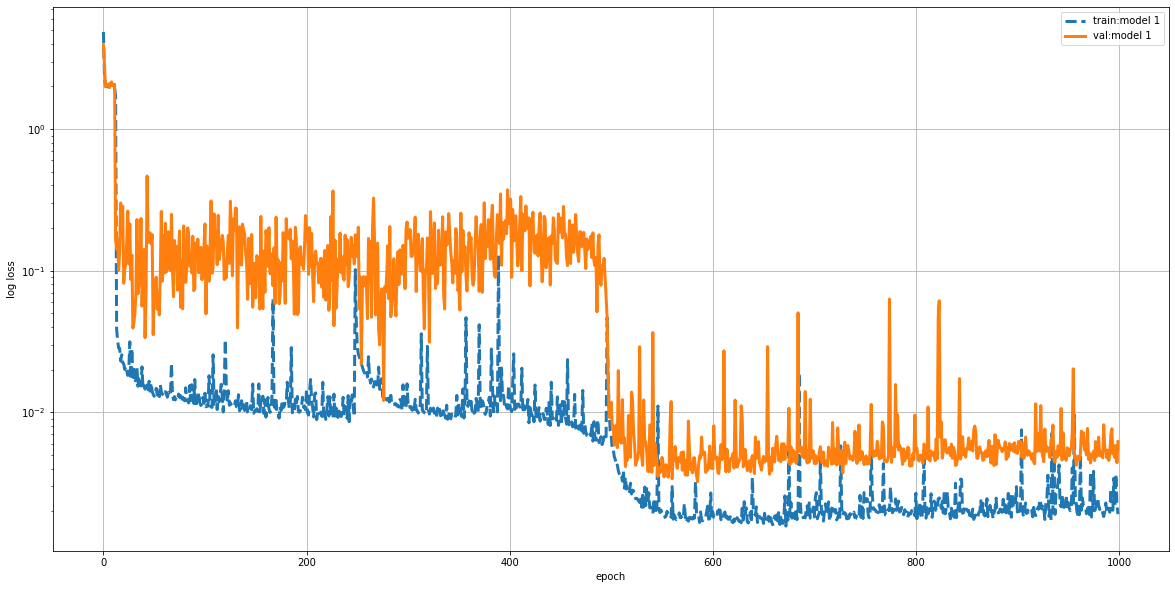

In [99]:
def plot_loss(hist,name,plt,RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
    plt.figure(figsize=(20,10))    
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)


plot_loss(h0.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.axis="off"
plt.show()

#### TEST validation images

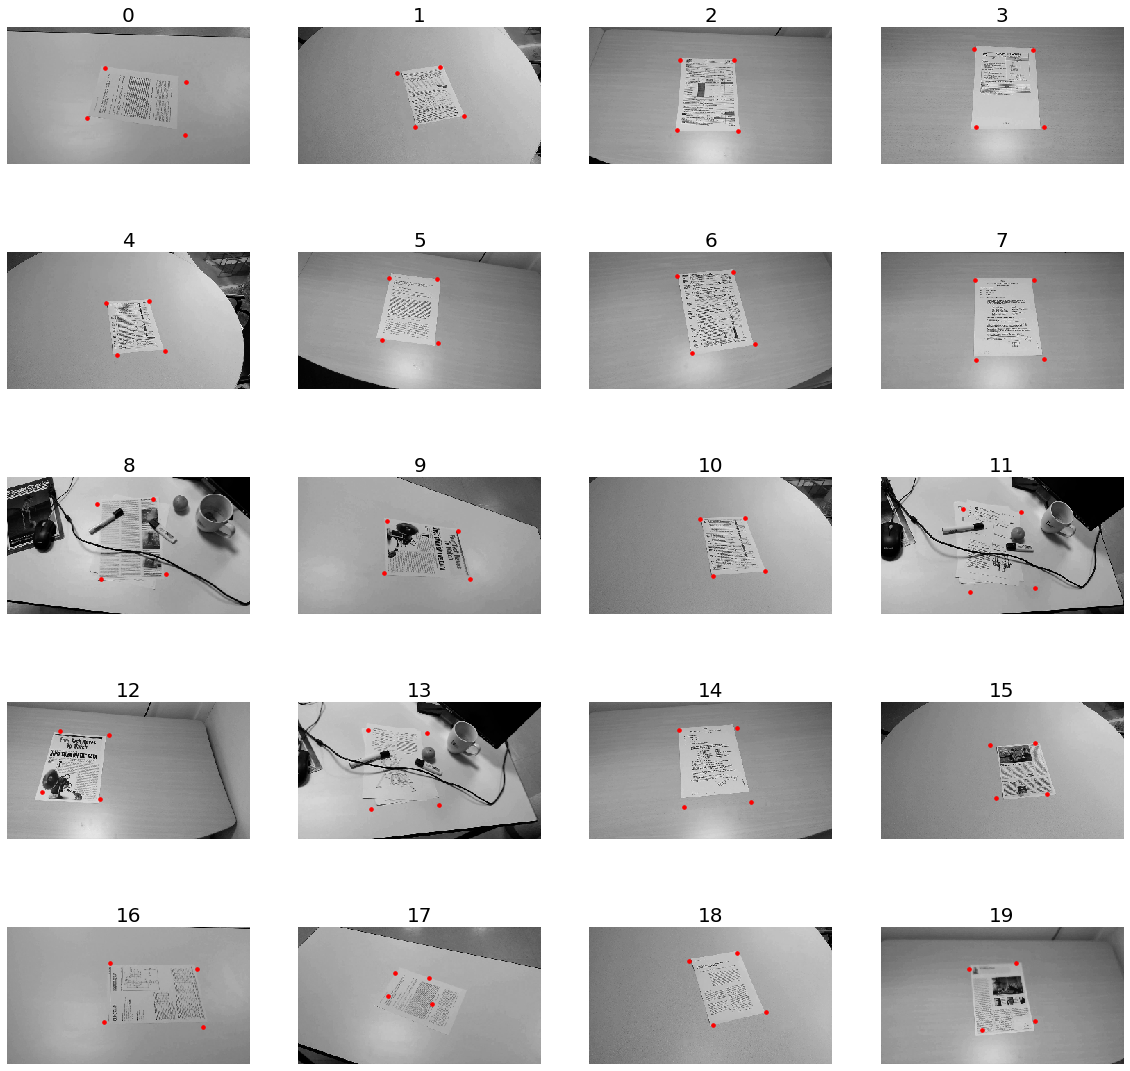

In [134]:
# show results
   
fig = plt.figure(figsize=(20,20))

ax1=0
for i,IDX in enumerate(range(20)):
    img_name = IDX
    val_img = X_val_[IDX].reshape(1,X_val_[IDX].shape[0],X_val_[IDX].shape[1],X_val_[IDX].shape[2])
    landmarks = simplecnn.predict(val_img)
    
    landmarks = landmarks.astype('float').reshape(-1, 2)
    
    ax1 = fig.add_subplot(5,4,i+1)
    show_landmarks(str(img_name),ax1,Image.fromarray(X_val_[IDX].reshape(H,W)),landmarks)
    ax1.set
plt.show()

#### TEST on my smartphone images

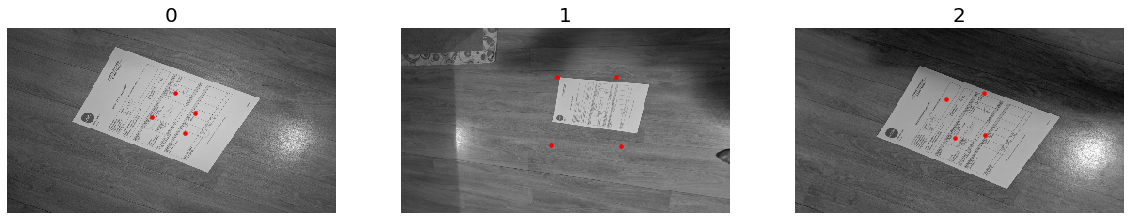

In [143]:
# show results
def show_landmarks(name,ax,image, landmarks):
    """Show image with landmarks"""
    ax.imshow(image, interpolation='nearest')
    ax.scatter(landmarks[:, 0], landmarks[:, 1], s=50, marker='.', c='r')
    ax.set_title(name,fontsize=20)
    ax.axis("off")
    
fig = plt.figure(figsize=(20,20))

ax1=0
for i,idx in enumerate(range(3)):
    img_name = idx
    test_img = Image.open(os.path.join(test_path,os.listdir(test_path)[idx]))
    #resize
    resized_img = test_img.resize((1920, 1080), Image.BILINEAR)
    #grayscale
    gs_image =  np.array(resized_img.convert(mode='L'),dtype="float").reshape(1080,1920,1)
    # resize image
    image_sc, scale = resize_image(gs_image,300,350)
    #preditct
    pred_landmarks = simplecnn.predict(image_sc.reshape(1,H,W,1))
    landmarks = pred_landmarks.reshape(-1, 2)
    
    ax1 = fig.add_subplot(1,3,i+1)
    show_landmarks(str(img_name),ax1,Image.fromarray(image_sc),landmarks)
    ax1.set
plt.show()

### SAVE AND LOAD MODEL

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
from tensorflow.keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")

#### NICETOHAVE COCO DATASET REMAKE (IN PROGRESS)

In [ ]:
# Create Coco Annotation files
AREA=BLX=BLY=BRX=BRY=TLX=TLY=TRX=TRY=ID=IMG_ID=xmin=xmax=ymin=ymax=filename=height=width=0

CAT_ANNOT  ={
            "supercategory": "document",
            "id": 1,
            "name": "document",
            "keypoints": [
                "bl","br","tl","tr"
            ],
            "skeleton": [
                [1,2],[1,3],[2,4],[3,4]
            ]
        }

ANNOT = {
            "segmentation": [[]],
            "num_keypoints": 4,
            "area": AREA,
            "iscrowd": 0,
            "keypoints": [BLX,BLY,2,BRX,BRY,2,TLX,TLY,2,TRX,TRY,2],
            "image_id": IMG_ID,
            "bbox": [xmin, ymin, xmax-xmin, ymax-ymin],
            "category_id": 1,
            "id": ID
        }
IMAGE = {
      "file_name": filename,
      "height": height,
      "width": width,
      "id": IMG_ID
    }


COCO_ANNOT  = {
  "images": [

  ],
    "categories": [

    ],
    "annotations": [

    ]
}
COCO_ANNOT["images"].append(IMAGE)
COCO_ANNOT["categories"].append(CAT_ANNOT)
COCO_ANNOT["annotations"].append(ANNOT)
COCO_ANNOT